In [42]:
# 標準ライブラリ
import os

# サードパーティ製ライブラリ
import matplotlib.pyplot as plt
#import paretoset

import pandas as pd

import matplotlib.pyplot as plt
import matplotlib as mpl
from pandas.plotting import parallel_coordinates
import numpy as np

import math
import pandas as pd
#import paretoset


# その他のライブラリ
import lab.moea.post as lmp
import lab.moea.viz as lmv

# 作業ディレクトリの確認
os.getcwd()

'/rst1_data/workspace3/kitada.r/PCAMOEAtrue/python'

In [43]:
# 計算結果の起点となるパス
output_base_path = '../output/pca0702/'

# リファレンスデータセット（パレートフロント・データセット）のベースパス
refset_base_path = '../pf'

# 目的関数の数
nobj = 2
# ベンチマーク問題
pNames = ['DTLZ2','DTLZ3']
# 最適化アルゴリズム
aNames = ['NSGAII-LAB', 'NSGAIIPOD']
aNamesLabel = {'NSGAII-LAB':'NSGA-II',
               'nelem1000-p100-NFE300000-v1000-obj2-sbxprob20%NSGAIIPOD':'with PCA 1000',}
nelems = ["nelem1000-p100-NFE300000-v1000-obj2-sbxprob20%" ]# 試行回数
ntrial = 3



In [44]:
def linestyle_generator():
    """Generate default linestyle"""
    linestyles = ['solid', 'dotted', 'dashed', 'dashdot',
                  (0, (5, 1)),  # densely dashed
                  (0, (5, 5))]  # dashed
    while True:
        for linestyle in linestyles:
            yield linestyle


def marker_generator():
    """Generate default marker"""
    markers = ['o', 's', '^', 'D', 'v', '+']
    while True:
        for marker in markers:
            yield marker


def markersize_generator():
    """Generate default markersize"""
    while True:
        yield 6

In [45]:
def plot_accumDatas(accumDatas, labels, x_attr_name, y_attr_name, xlabel, ylabel,
                    loc=None, anchor=None, yscale=None, marker=None):
    """Plot accumulator datasets

    Args:
        accumDatas (set): Set of accumulator datasets
        x_attr_name (str): Column name of data frame for horizontal axis
        y_attr_name (str): Column name of data frame for vertival axis
        xlabel (str): Name for horizontal axis
        ylabel (str): Name for vertical axis
        loc: loc option for legend function
        anchor: bbox_to_anchor option for legend function
        yscale (str): sclale option (e.g. 'log')
        marker (boolean): plot marker if True

    Returns:
        Figure object
    """

    fig = plt.figure(figsize=(8, 7), dpi=100)  # figure size
    plt.rcParams["font.size"] = 22  # whole font size

    ax = fig.add_subplot(1, 1, 1)
    ax.set_axisbelow(True)

    linestyle_gen = linestyle_generator()
    marker_gen = marker_generator()
    markersize_gen = markersize_generator()

    for k, df in accumDatas.items():
        x = df[x_attr_name]
        y = df[y_attr_name]
        if marker is None:
            plt.plot(x, y, label=labels[k],
                     linestyle=next(linestyle_gen))
        else:
            plt.plot(x, y, label=labels[k],
                     linestyle=next(linestyle_gen),
                     marker=next(marker_gen),
                     markersize=next(markersize_gen))

    plt.grid(ls='--')

    plt.xlabel(xlabel)
    plt.ylabel(ylabel)

    if yscale == 'log':
        plt.yscale("log")

    if anchor is None:
        anchor = (1, 1)

    if loc is None:
        loc = 'upper left'

    ax.legend(loc=loc, bbox_to_anchor=anchor)

    plt.show()

    return fig

In [46]:
def makeMeanAccumDatas(path, nelems ,aNames, ntrial):
    """Calculate the mean from all trial results
    and save results into mean_accum.csv

    Final path of accum_img.csv is 'path/[aName]/[0, ntrial]/accum_img.csv'.

    Final path of mean_accm.csv is 'path/[aName]/mean_accm.csv'

    Args:
        path (str): Base path of input/output data
        aNames (list): Array of algorithm names
        ntrial (int): The number of trial
    """
    for nelem in nelems:

        for aName in aNames:
            accum_path = '{}/{}/{}'.format(path, nelem,aName)
            meanAccumData = calcMeanAccumData(accum_path, ntrial)
            output_path = '{}/{}/{}/{}'.format(path,nelem,aName, 'mean_accum.csv')
            meanAccumData.to_csv(output_path, index=False)  # save results


In [47]:
def loadMeanAccumDatas(path, nelems,aNames):
    """Load mean_accm.csv for each algorithm

    Final path of mean_accm.csv is 'base_path/[aName]/mean_accm.csv'

    Args:
        path (str): Base path of mean_accm.csv
        aNames (list): Array of algorithm names

    Returns:
        meanAccumDatas (dict): Loaded mean data stored in dictitonary format
    """

    meanAccumDatas = {}
    i=True
    for nelem in nelems:
        for aName in aNames:
            if(i==True):
                accum_path = '{}/{}/{}/mean_accum.csv'.format(path,nelem ,aName)
                meanAccumData = loadCsvData(accum_path)
                meanAccumDatas[aName] = meanAccumData
                i=False
            else:
                accum_path = '{}/{}/{}/mean_accum.csv'.format(path,nelem ,aName)
                meanAccumData = loadCsvData(accum_path)
                meanAccumDatas[nelem+aName] = meanAccumData
                i=True
    return meanAccumDatas

In [48]:
def calcMeanAccumData(path, ntrial):
    """Calculate mean from all trial results(accum_img.csv)

    Final path of accum_img.csv is 'path/[0, ntrial]/accum_img.csv'.

    Args:
        path (str): Base path of accum_img.csv
        ntrial (int): The number of trial
    Returns:
        meanAccumSet (DataFrame): Mean results
    """

    for i in range(0, ntrial):
        accum_path = '{}/{}/accum_img.csv'.format(path, str(i))
        accumSet = loadCsvData(accum_path)
        if i == 0:
            meanAccumSet = accumSet
        else:
            meanAccumSet += accumSet

    meanAccumSet /= ntrial

    return meanAccumSet

In [49]:
def loadCsvData(path):
    """Load CSV dataset as dataframe"""
    return pd.read_csv(path, delimiter=',')

In [50]:
for pName in pNames:
    # リファレンスデータセットのファイル名を含むパス（DTLZ, WFGシリーズの場合）
    refset_path = '{}/{}.{}.pf'.format(refset_base_path, pName, str(nobj))
    # 計算結果のパス（目的関数を追加。この下にアルゴリズム/試行
    base_path = '{}/{}/'.format(output_base_path, pName) #modified
    # 計算結果のパス（目的関数を追加。この下にアルゴリズム/試行
    base_path = '{}/{}/'.format(output_base_path, pName) #modified
    # 評価値の平均値を計算しファイルに保存する(1度だけ実行すればよい)
    makeMeanAccumDatas(base_path,nelems,aNames,ntrial)
    # 計算した平均値の読み込み
    meanAccumDatas = loadMeanAccumDatas(base_path,nelems,aNames)
    # 評価値の平均値の可視化
    print(meanAccumDatas)

{'NSGAII-LAB':            NFE  Elapsed Time  GenerationalDistance  Hypervolume     ITE  \
0        100.0      0.011988             16.478186     0.000000     1.0   
1        200.0      0.112539             14.684306     0.000000     2.0   
2        300.0      0.177520             17.790334     0.000000     3.0   
3        400.0      0.236578             16.749139     0.000000     4.0   
4        500.0      0.294613             15.911569     0.000000     5.0   
...        ...           ...                   ...          ...     ...   
2995  299600.0    293.359899              0.008117     0.113709  2996.0   
2996  299700.0    293.471602              0.008076     0.113777  2997.0   
2997  299800.0    293.582152              0.008117     0.113906  2998.0   
2998  299900.0    293.691868              0.008109     0.113996  2999.0   
2999  300000.0    293.802166              0.008076     0.114108  3000.0   

      InvertedGenerationalDistance  
0                        77.656886  
1         

NSGAII-LAB
{'NSGAII-LAB': 'NSGA-II', 'nelem1000-p100-NFE300000-v1000-obj2-sbxprob20%NSGAIIPOD': 'with PCA 1000'}
NSGA-II
nelem1000-p100-NFE300000-v1000-obj2-sbxprob20%NSGAIIPOD
{'NSGAII-LAB': 'NSGA-II', 'nelem1000-p100-NFE300000-v1000-obj2-sbxprob20%NSGAIIPOD': 'with PCA 1000'}
with PCA 1000


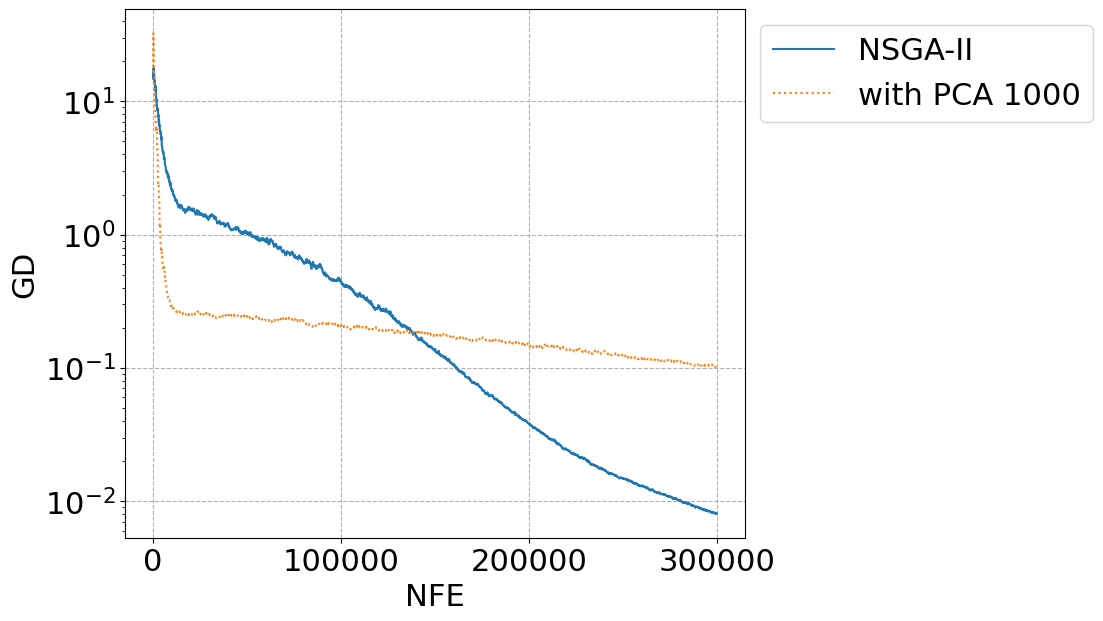

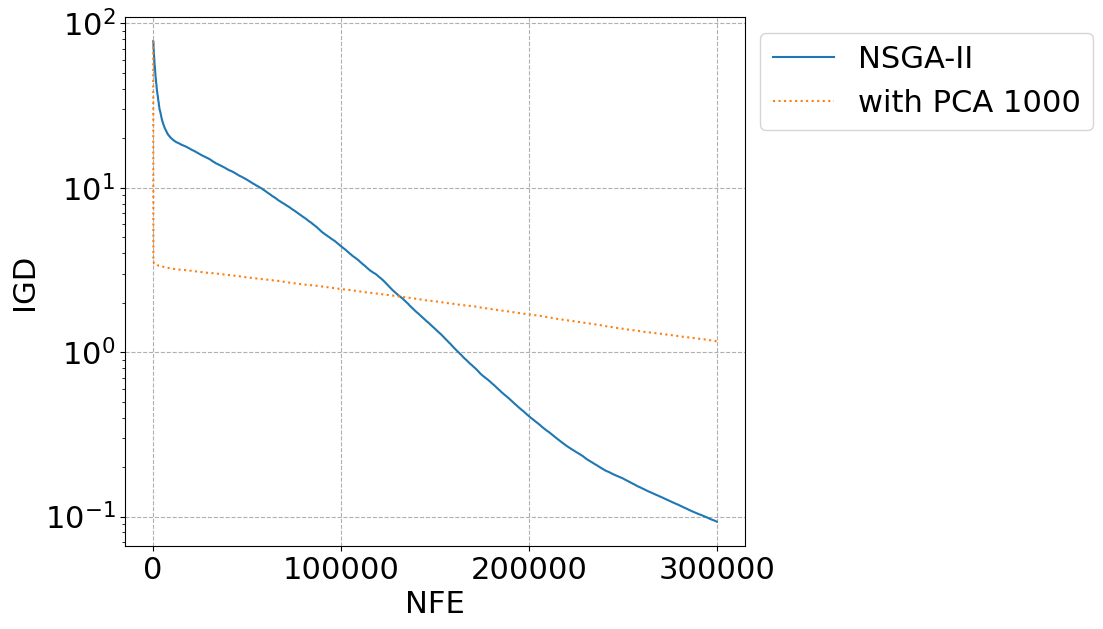

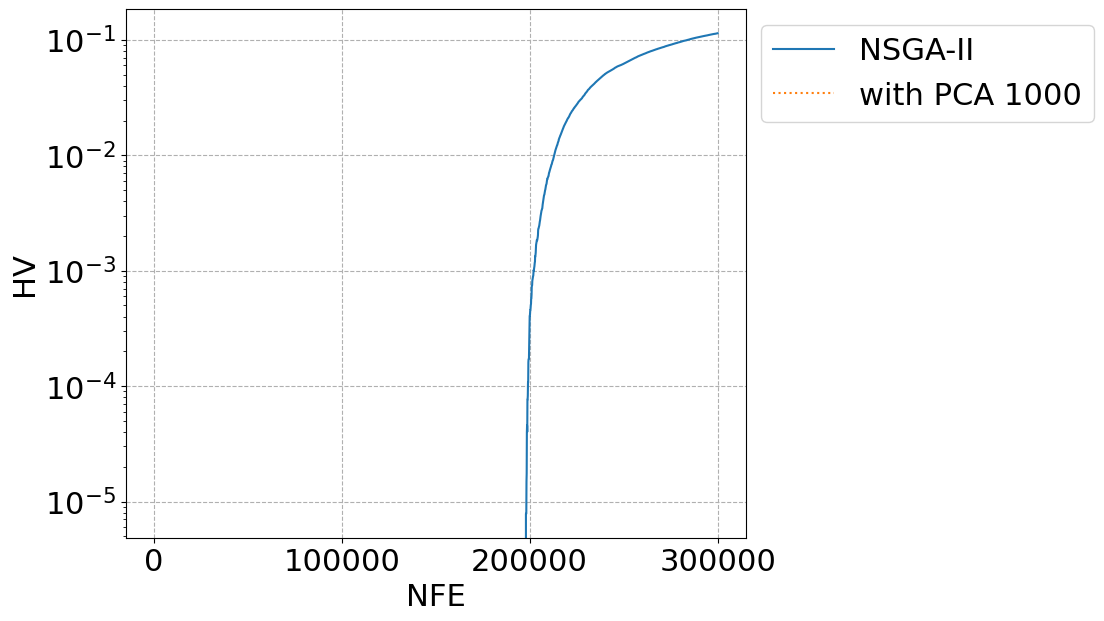

NSGAII-LAB
{'NSGAII-LAB': 'NSGA-II', 'nelem1000-p100-NFE300000-v1000-obj2-sbxprob20%NSGAIIPOD': 'with PCA 1000'}
NSGA-II
nelem1000-p100-NFE300000-v1000-obj2-sbxprob20%NSGAIIPOD
{'NSGAII-LAB': 'NSGA-II', 'nelem1000-p100-NFE300000-v1000-obj2-sbxprob20%NSGAIIPOD': 'with PCA 1000'}
with PCA 1000


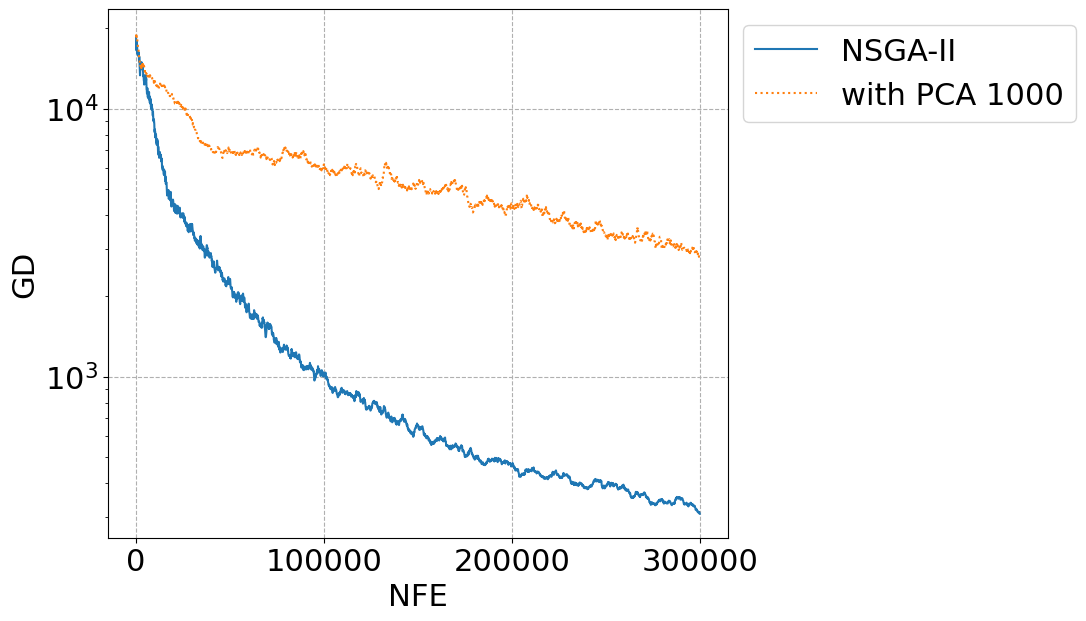

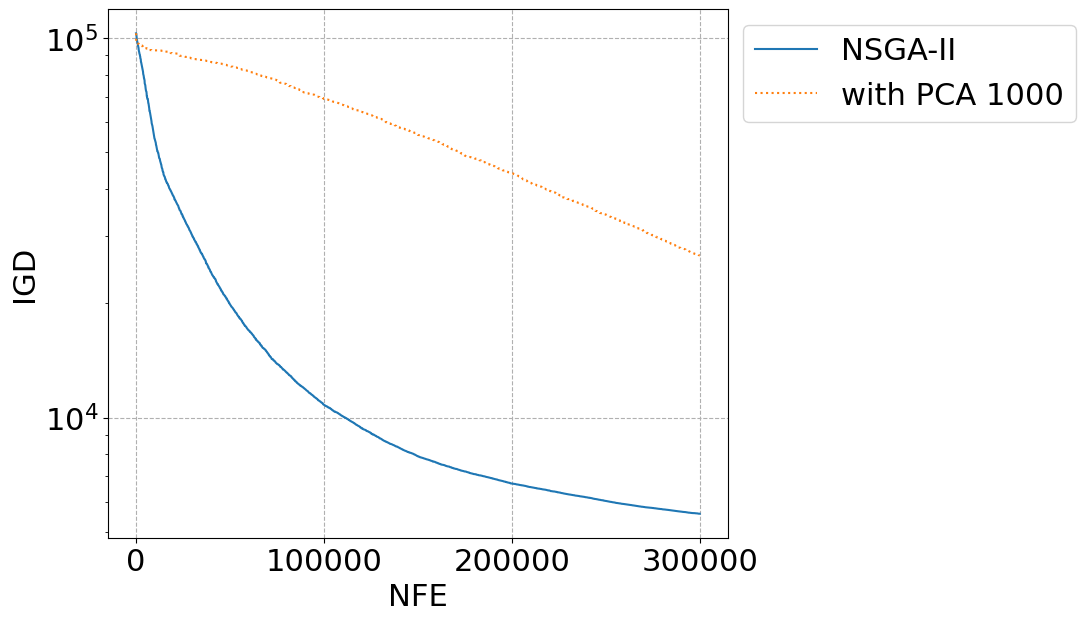

/tmp/ipykernel_2366597/783159492.py:48: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  plt.yscale("log")


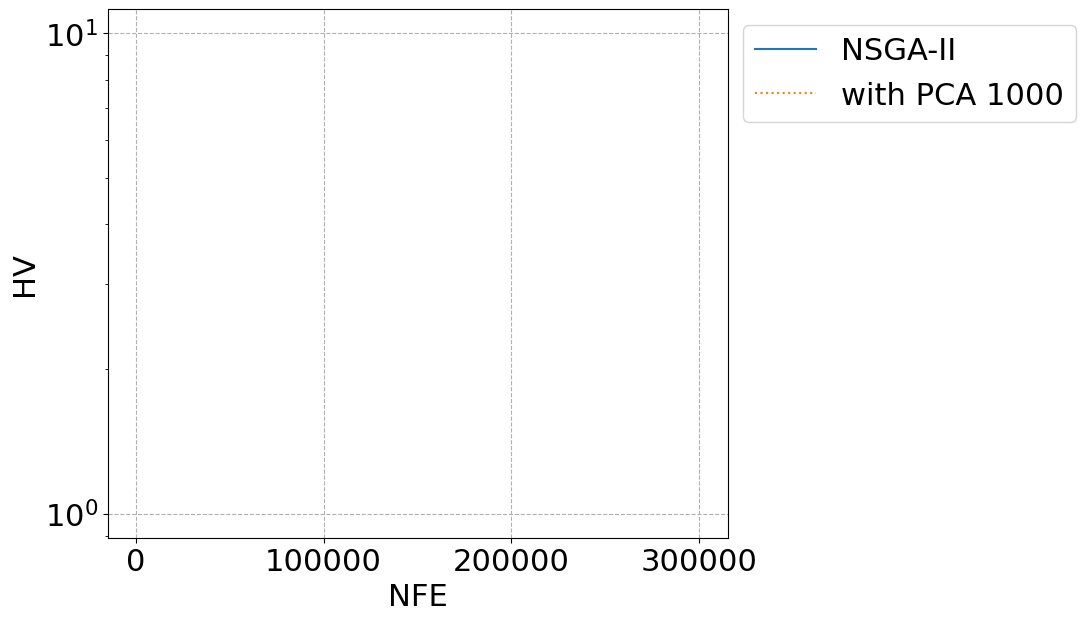

In [54]:
for pName in pNames:
    # 計算結果のパス（目的関数を追加。この下にアルゴリズム/試行
    base_path = '{}/{}/'.format(output_base_path, pName) #modified
    # 評価値の平均値を計算しファイルに保存する(1度だけ実行すればよい)
    makeMeanAccumDatas(base_path,nelems,aNames,ntrial)
    # 計算した平均値の読み込み
    meanAccumDatas = loadMeanAccumDatas(base_path, nelems,aNames)
    for k, df in meanAccumDatas.items():
        print(k)
        print(aNamesLabel)
        print(aNamesLabel[k])

    # 評価値の平均値の可視化
    fig = plot_accumDatas(meanAccumDatas,aNamesLabel, 'NFE', 'GenerationalDistance', 'NFE', 'GD', 'upper left', (1, 1),"log")
    fig.savefig(base_path+"1000_compareGD.png", bbox_inches='tight')
    fig = plot_accumDatas(meanAccumDatas ,aNamesLabel, 'NFE', 'InvertedGenerationalDistance', 'NFE', 'IGD', 'upper left', (1, 1),"log")
    fig.savefig(base_path+"1000_compareIGD.png", bbox_inches='tight')
    fig = plot_accumDatas(meanAccumDatas,aNamesLabel, 'NFE', 'Hypervolume', 'NFE', 'HV', 'upper left', (1, 1),"log")
    fig.savefig(base_path+"1000_compareHV.png", bbox_inches='tight')

In [11]:
# リファレンスデータセット（パレートフロント・データセット）を読み込む
refset = lmp.loadReferenceSet(refset_path, nobj)
# リファレンスデータセットhistoryの可視化
fig = lmv.scatter2D_obj_history_with_referenceset(history, refset)

FileNotFoundError: [Errno 2] No such file or directory: '../pf/DTLZ4.2.pf'

In [ ]:
# history_pf.txtファイルの読み込み
trial = 0
aName = aNames[1]
history = lmp.HistoryData('{}/{}/{}/history_pf.txt'.format(base_path, 'nelem_adaptive-p10-NFE100-v1000'+"/"+aName, str(trial)))



In [ ]:
f = open('{}/{}/{}/history_pf.txt'.format(base_path, 'nelem_adaptive-p10-NFE100-v1000'+"/"+aName, str(trial)), "r", encoding="ms932", errors="", newline="" )
f = csv.reader(csv_file, delimiter=",", doublequote=True, lineterminator="\r\n", quotechar='"', skipinitialspace=True)


In [ ]:
dataset=pd.read_table('{}/{}/{}/history_pf.txt'.format(base_path, 'nelem_adaptive-p10-NFE100-v1000'+"/"+aName, str(trial)),sep=",")
dataset

In [ ]:
for pName in pNames:
    # 計算結果のパス（目的関数を追加。この下にアルゴリズム/試行
    base_path ='{}/{}/'.format(output_base_path, pName) #modified
    dataset=pd.read_table('{}/{}/{}/history_pf.txt'.format(base_path, 'nelem_adaptive-p10-NFE100-v1000'+"/"+aName, str(trial)),sep=",")

    fig = plt.figure(figsize=(8, 7), dpi=100)  # figure size
    plt.rcParams["font.size"] = 22  # whole font size
    
    ax = fig.add_subplot(1, 1, 1)
    ax.set_axisbelow(True)

    linestyle_gen = linestyle_generator()
    marker_gen = marker_generator()
    markersize_gen = markersize_generator()
    x = dataset["NFE"]
    y = dataset["mode"]
    plt.plot(x, y, label="number of pc",
                         linestyle=next(linestyle_gen),
                         marker=next(marker_gen),
                         markersize=next(markersize_gen))
    plt.grid(ls='--')
    loc = 'upper left'
    anchor = (1, 1)

    ax.legend(loc=loc, bbox_to_anchor=anchor)
    plt.yscale("log")

    plt.xlabel("NFE")
    plt.ylabel("mode")
    print(base_path)
    plt.savefig(base_path+'nelem_adaptive-p10-NFE100-v1000'+"/"+aName+"/"+ str(trial)
    +"pcanumDTLZ4.png", bbox_inches='tight')

    plt.show()



In [ ]:
base_path = '{}/{}/'.format(output_base_path, pName) #modified


In [ ]:
def scatter2D_obj_history_with_referenceset(history, referenceSet):
    """Draw 2-dimensional objective space by history with reference set

    It's colored by NFE value.

    Args:
        history (dataframe): Data frame of history

    Returns:
        Figure object
    """

    fig = plt.figure(figsize=(8, 7), dpi=100)  # figure size
    plt.rcParams["font.size"] = 22  # whole font size

    ax = fig.add_subplot(1, 1, 1)
    ax.set_axisbelow(True)

    cmap = plt.get_cmap('rainbow')

    nfes = history.getNFESet()

    for i in nfes:
        objs = history.getObjByNFE(i)
        cs = history.getNFEByNFE(i)
        sc = plt.scatter(objs.f0, objs.f1, s=10, c=cs, cmap=cmap,
                         vmin=0, vmax=history.getNumberOfEvaluations())

    """Plot reference set"""
    ref_s = referenceSet.sort_values('f0')
    plt.plot(ref_s.f0, ref_s.f1)
    plt.grid(ls='--')

    plt.xlabel('$f_1$')
    plt.ylabel('$f_2$')

    plt.colorbar(sc, label='NFE')

    plt.show()


In [ ]:
for pName in pNames:
    # リファレンスデータセットのファイル名を含むパス（DTLZ, WFGシリーズの場合）
    refset_path = '{}/{}.{}.pf'.format(refset_base_path, pName, str(nobj))
    # 計算結果のパス（目的関数を追加。この下にアルゴリズム/試行
    base_path = '{}/{}/'.format(output_base_path, pName) #modified
    # 計算結果のパス（目的関数を追加。この下にアルゴリズム/試行
    base_path = '{}/{}/'.format(output_base_path, pName) #modified
    # 評価値の平均値を計算しファイルに保存する(1度だけ実行すればよい)
    makeMeanAccumDatas(base_path,nelems,aNames,ntrial)
    # 計算した平均値の読み込み
    meanAccumDatas = loadMeanAccumDatas(base_path,nelems,aNames)
    # 評価値の平均値の可視化
    print(meanAccumDatas)

In [ ]:
for pName in pNames:
    # 計算結果のパス（目的関数を追加。この下にアルゴリズム/試行
    base_path = '{}/{}/'.format(output_base_path, pName) #modified
    # 評価値の平均値を計算しファイルに保存する(1度だけ実行すればよい)
    makeMeanAccumDatas(base_path,nelems,aNames,ntrial)
    # 計算した平均値の読み込み
    meanAccumDatas = loadMeanAccumDatas(base_path, nelems,aNames)
    # 評価値の平均値の可視化
    fig = plot_accumDatas(meanAccumDatas,aNamesLabel, 'NFE', 'GenerationalDistance', 'NFE', 'GD', 'upper left', (1, 1))
    fig.savefig(base_path+"1000_compareGD.png", bbox_inches='tight')
    fig = plot_accumDatas(meanAccumDatas ,aNamesLabel, 'NFE', 'InvertedGenerationalDistance', 'NFE', 'IGD', 'upper left', (1, 1))
    fig.savefig(base_path+"1000_compareIGD.png", bbox_inches='tight')
    fig = plot_accumDatas(meanAccumDatas,aNamesLabel, 'NFE', 'Hypervolume', 'NFE', 'HV', 'upper left', (1, 1))
    fig.savefig(base_path+"1000_compareHV.png", bbox_inches='tight')

In [52]:
for pName in pNames:
    # 計算結果のパス（目的関数を追加。この下にアルゴリズム/試行
    base_path = '{}/{}/'.format(output_base_path, pName) #modified
    print(base_path)

../output/pca0702//DTLZ2/
../output/pca0702//DTLZ3/


../output/pca0702//DTLZ2/
../output/pca0702//DTLZ2//nelem1000-p100-NFE300000-v1000-obj2-sbxprob20%/NSGAII-LAB/0/history_pf.txt


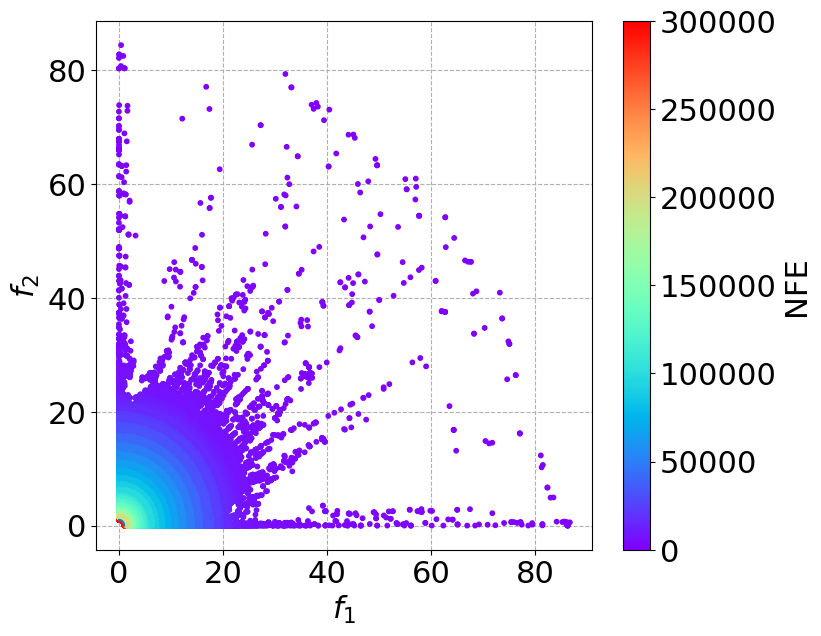

../output/pca0702//DTLZ2//nelem1000-p100-NFE300000-v1000-obj2-sbxprob20%/NSGAIIPOD/0/history_pf.txt


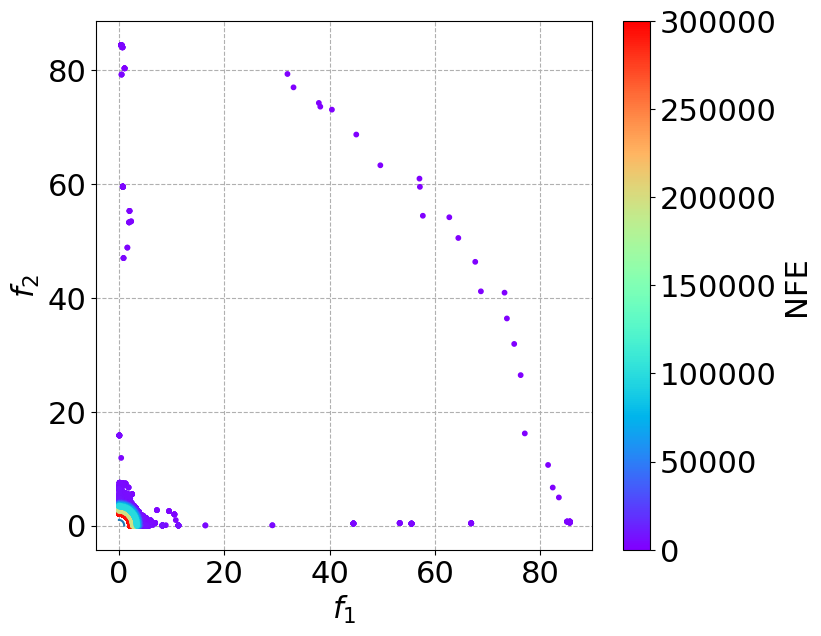

../output/pca0702//DTLZ3/
../output/pca0702//DTLZ3//nelem1000-p100-NFE300000-v1000-obj2-sbxprob20%/NSGAII-LAB/0/history_pf.txt


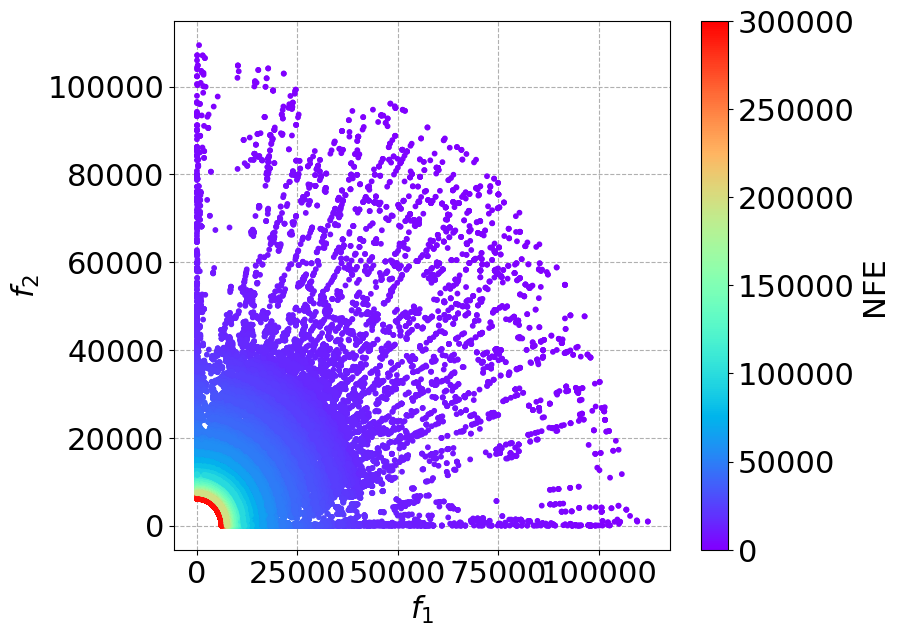

../output/pca0702//DTLZ3//nelem1000-p100-NFE300000-v1000-obj2-sbxprob20%/NSGAIIPOD/0/history_pf.txt


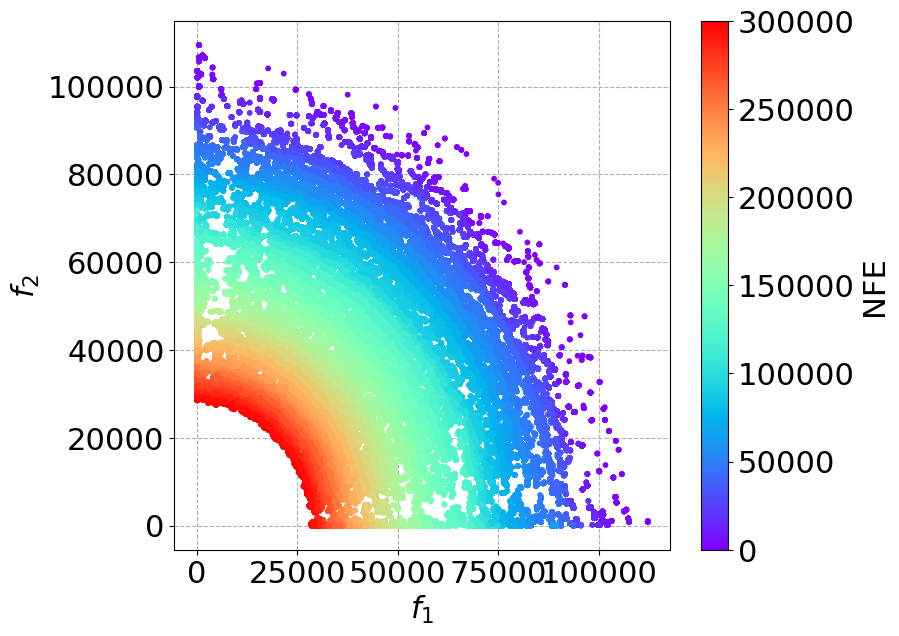

In [53]:
# history_pf.txtファイルの読み込み
for pName in pNames:
    # リファレンスデータセットのファイル名を含むパス（DTLZ, WFGシリーズの場合）
    refset_path = '{}/{}.{}D.pf'.format(refset_base_path, pName, str(nobj))
    # 計算結果のパス（目的関数を追加。この下にアルゴリズム/試行
    base_path = '{}/{}/'.format(output_base_path, pName) #modified
    print(base_path)
    trial = 0
    for aName in aNames:
        for nelem in nelems:
            print('{}/{}/{}/{}/history_pf.txt'.format(base_path,nelem ,aName, str(trial)))
            history = lmp.HistoryData('{}/{}/{}/{}/history_pf.txt'.format(base_path,nelem ,aName, str(trial)))
            # historyの可視化
            # リファレンスデータセット（パレートフロント・データセット）を読み込む
            refset = lmp.loadReferenceSet(refset_path, nobj)
            fig = lmv.scatter2D_obj_history_with_referenceset(history, refset)
            
            fig.savefig(base_path+"/"+nelem+"/"+aName, bbox_inches='tight')
           

In [ ]:
# 設計変数の並行座標プロット
fig = lmv.parallel_coordinates_var_history(history)
# 設計変数の履歴の可視化(変数のサブセットを可視化)
variable_ids = [i for i in range(2, 4)]
fig = lmv.scatter2D_var_history(history, variable_ids)
# 設計変数の履歴の可視化(全変数を可視化)
fig = lmv.scatter2D_var_history(history)